In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from random import randint, uniform, gauss
import math
import numpy as np
import matplotlib.pyplot as plt

In [34]:
C_train = 100000
alpha = 0.23
error_all = 0.23

X_train = []
y_train = []
for i in range(C_train):
    xi = uniform(0, 30)
    eps = gauss(0, error_all)
    si = xi + eps
    xi1 = math.exp(alpha * si + eps)
    X_train.append([xi])
    y_train.append([xi1])

X_train = torch.tensor(X_train, dtype=torch.float32).view(-1, 1)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

In [35]:
backbone = nn.Sequential(nn.Linear(1, 32), nn.ReLU(), nn.Linear(32, 32), nn.ReLU())

head_x = nn.Linear(32, 1)
head_sigma = nn.Linear(32, 1)
softplus = nn.Softplus()

params = list(backbone.parameters()) + list(head_x.parameters()) + list(head_sigma.parameters())
opt = optim.Adam(params, lr=10**(-3))

In [36]:
batch = 1024
epochs = 30

for k in range(epochs):
    pos = torch.randperm(X_train.size(0))
    ans = 0
    cnt = 0
    for i in range(0, X_train.size(0), batch):
        ind = pos[i:i + batch]
        x_now = X_train[ind]
        y_now = y_train[ind]
        
        res = backbone(x_now)
        x_ok = softplus(head_x(res))
        sigma_ok = softplus(head_sigma(res)) + 1e-6
        loss = ((y_now - x_ok) ** 2) / (2.0 * sigma_ok ** 2) + torch.log(sigma_ok)
        loss = loss.mean()

        opt.zero_grad()
        loss.backward()
        opt.step()
        ans += loss.item()
        cnt += 1

    print("iter ", k + 1, ", loss = ", ans / cnt, sep='')

iter 1, loss = 1731.6334315708705
iter 2, loss = 158.43496081293847
iter 3, loss = 66.5290525008221
iter 4, loss = 42.13931768767688
iter 5, loss = 30.52655552844612
iter 6, loss = 23.808618662308675
iter 7, loss = 19.44138092897376
iter 8, loss = 16.40262249537877
iter 9, loss = 14.176588622891174
iter 10, loss = 12.504175653263014
iter 11, loss = 11.200927812225965
iter 12, loss = 10.167160384509028
iter 13, loss = 9.32680429244528
iter 14, loss = 8.634956228489779
iter 15, loss = 8.051405347123438
iter 16, loss = 7.560725625680417
iter 17, loss = 7.141799007143293
iter 18, loss = 6.778868918516198
iter 19, loss = 6.464837448937552
iter 20, loss = 5.183519115253371
iter 21, loss = 4.507986078456956
iter 22, loss = 4.3846257608764025
iter 23, loss = 4.297077504955992
iter 24, loss = 4.227599119653507
iter 25, loss = 4.17419200770709
iter 26, loss = 4.122840973795677
iter 27, loss = 4.084577110348915
iter 28, loss = 4.053225780019955
iter 29, loss = 4.018497836833098
iter 30, loss = 3.

In [37]:
C_test = 10000
X_test = []
y_test = []
for i in range(C_test):
    xi = uniform(0, 3)
    eps = gauss(0, error_all)
    
    si = xi + eps
    xi1 = math.exp(alpha * si + eps)
    X_test.append([xi])
    y_test.append([xi1])

X_test = torch.tensor(X_test, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

mse_x = 0
nll = 0
for i in range(C_test):
    h = backbone(X_test[i])
    x_ok = softplus(head_x(h))
    sigma_ok = softplus(head_sigma(h)) + 1e-6
    mse_x += (y_test[i][0] - x_ok[0]) ** 2
    nll += (((y_test[i][0] - x_ok[0]) ** 2) / (2.0 * sigma_ok[0] ** 2) + torch.log(sigma_ok[0]))

mse_x /= C_test
nll /= C_test
print("MSE x =", mse_x.item())
print("NLL =", nll.item())


MSE x = 0.1996403932571411
NLL = -0.3384192883968353


In [38]:
C_iter = 50
col_test = 1000

need_x = [0] * (C_iter + 1)
res_x = [0] * (C_iter + 1)
sum_error_x = [0] * (C_iter + 1)

for iter1 in range(col_test):
    x0 = uniform(0, 1.5)
    x = torch.tensor([[x0]], dtype=torch.float32)
    x_true = torch.tensor([[x0]], dtype=torch.float32)
    res_x[0] += x0
    need_x[0] += x0

    for i in range(C_iter):
        eps = gauss(0, error_all)
        si = x_true + eps
        x_true = torch.exp(alpha * si + eps)

        need_x[i + 1] += x_true.item()

        h = backbone(x)
        x_ok = softplus(head_x(h))
        sigma_ok = softplus(head_sigma(h)) + 1e-6
        x = x_ok + sigma_ok * torch.randn_like(x_ok)
        x = torch.clamp(x, min=1e-6)
        res_x[i + 1] += x.item()

        sum_error_x[i + 1] += (x_true.item() - x.item()) ** 2

for i in range(C_iter + 1):
    need_x[i] /= col_test
    res_x[i] /= col_test
    sum_error_x[i] /= col_test

need_x = np.array(need_x)
res_x = np.array(res_x)
sum_error_x = np.array(sum_error_x)


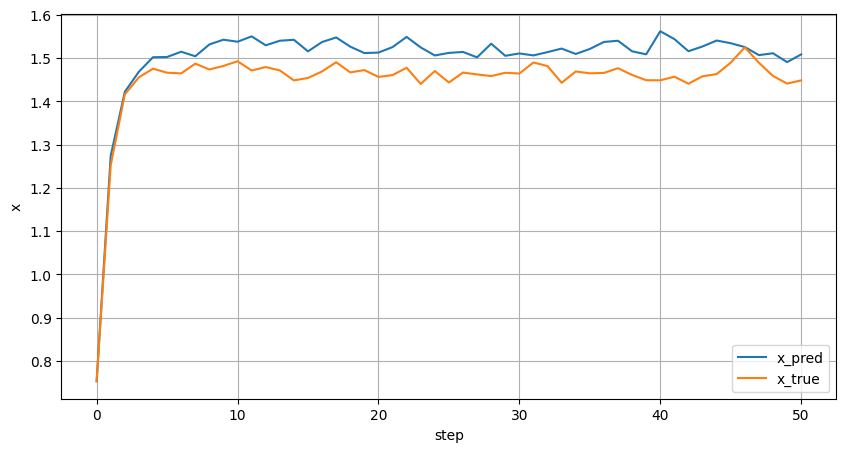

In [39]:
steps = np.arange(C_iter + 1)

plt.figure(figsize=(10, 5))
plt.xlabel("step")
plt.ylabel("x")
plt.plot(steps, res_x, label="x_pred")
plt.plot(steps, need_x, label="x_true")
plt.grid()
plt.legend()
plt.show()

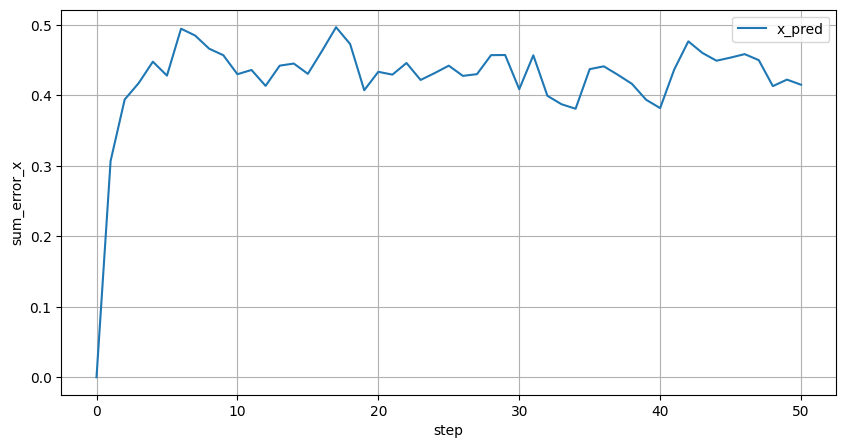

In [40]:
steps = np.arange(C_iter + 1)

plt.figure(figsize=(10, 5))
plt.xlabel("step")
plt.ylabel("sum_error_x")
plt.plot(steps, sum_error_x, label="x_pred")
plt.grid()
plt.legend()
plt.show()